In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from analyzer.metric import MetricCalculator
from data import Reader
from plot import Drawer
from analyzer.stat_criterion.stat_criteria import StatCriteria
from encoder import Encoder
from preparation import DataPreparation, Normalizer

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import Lasso

In [20]:
# Загружаем данные
df = Reader.read_csv('./dataset/df_elite.csv')


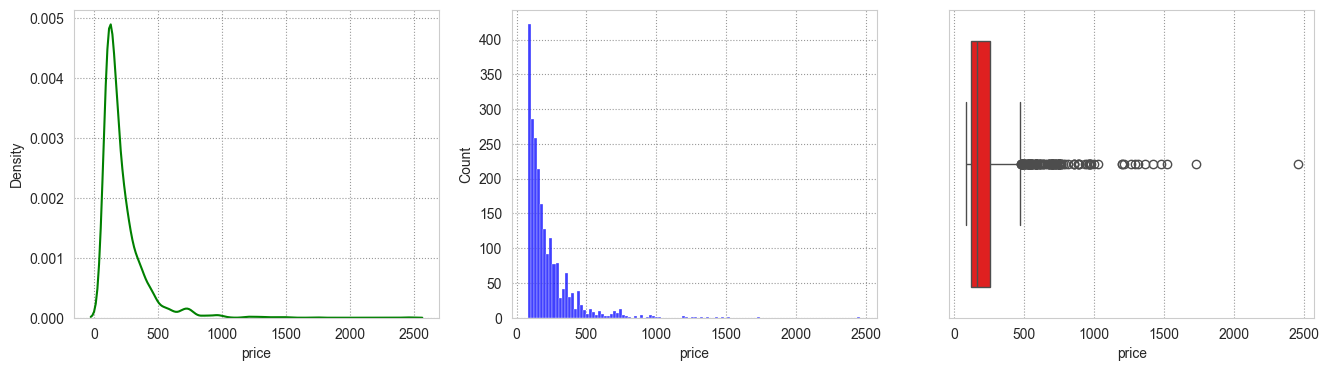

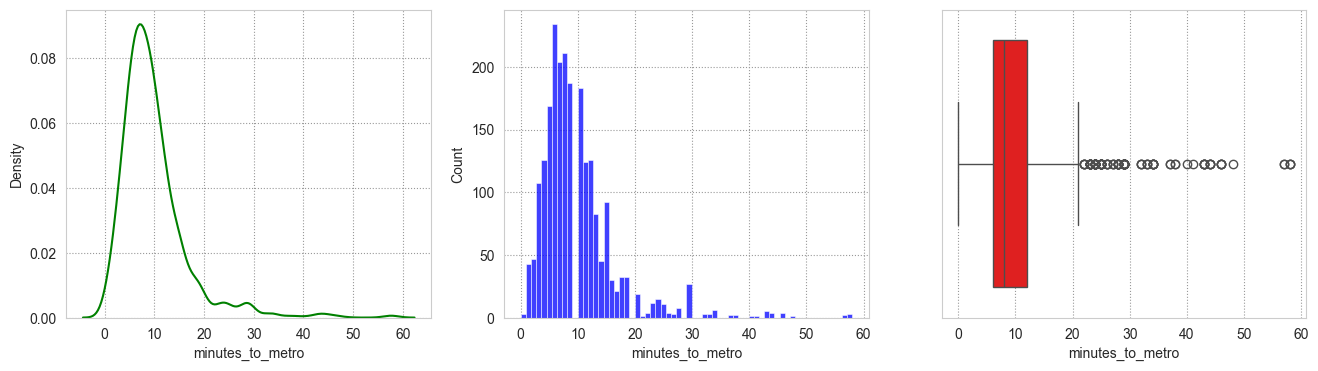

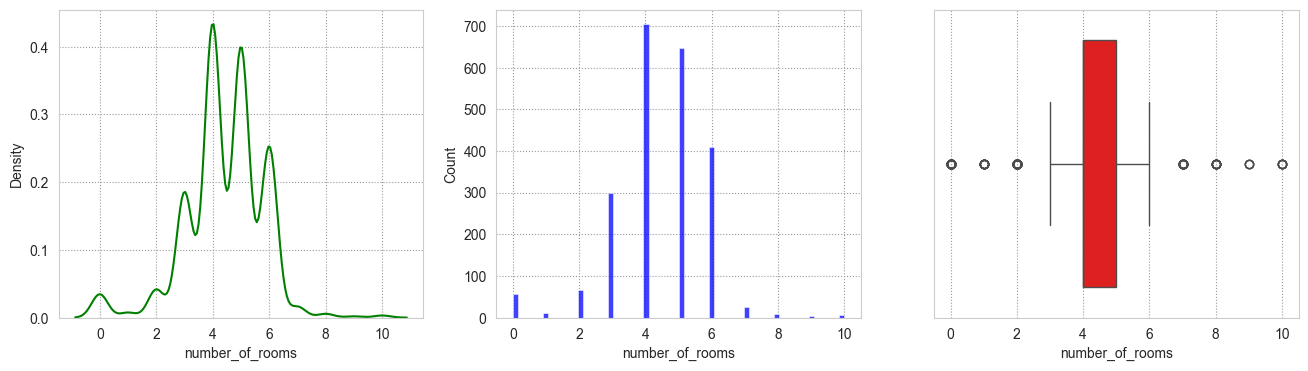

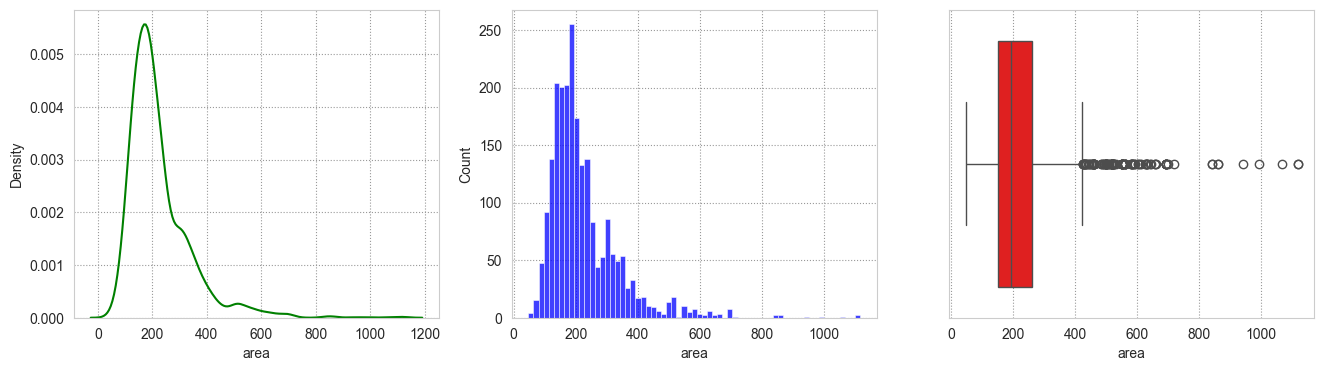

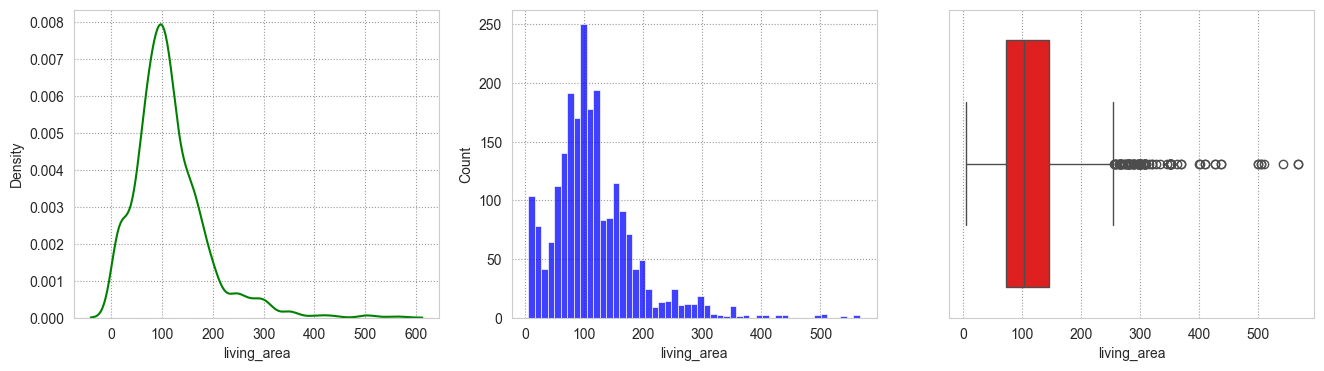

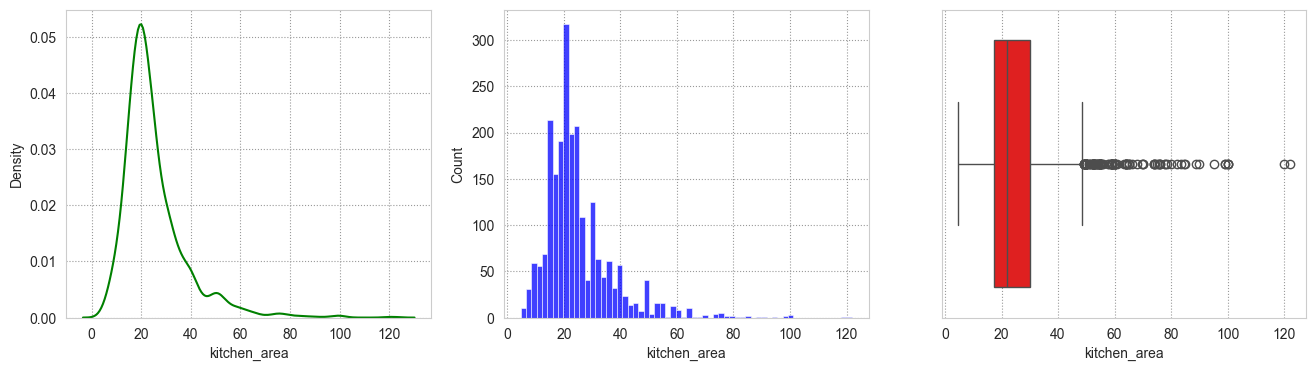

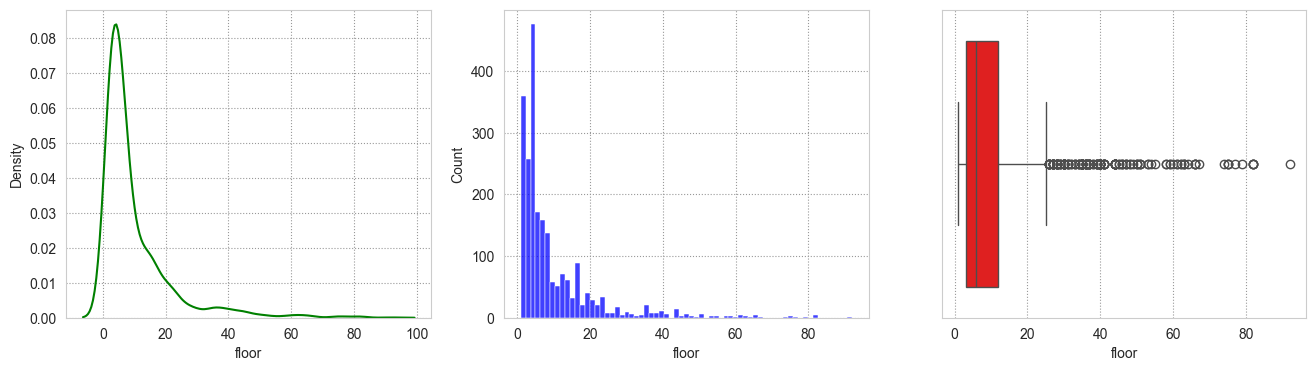

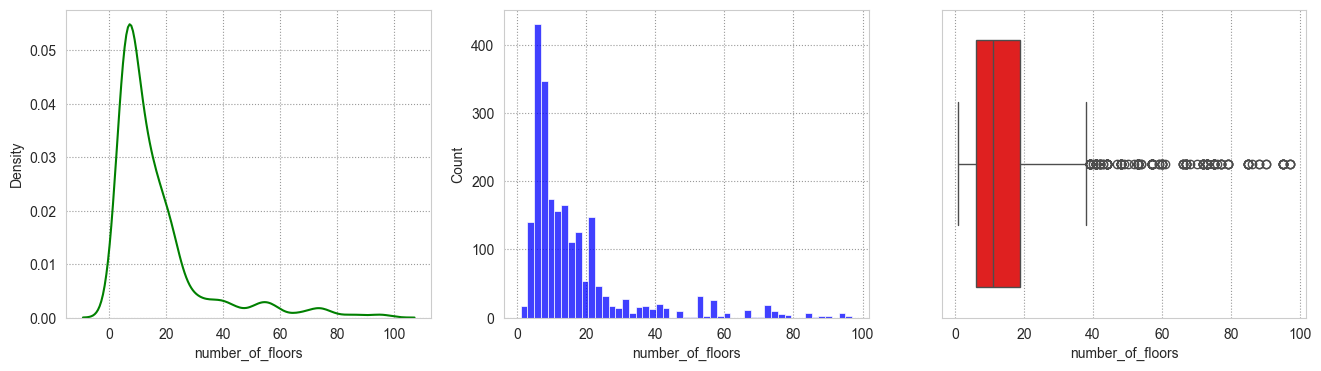

In [21]:
# ещё раз визуально оцениваем обычную недвижимость
Drawer.draw_kde_hist_boxplot(df)

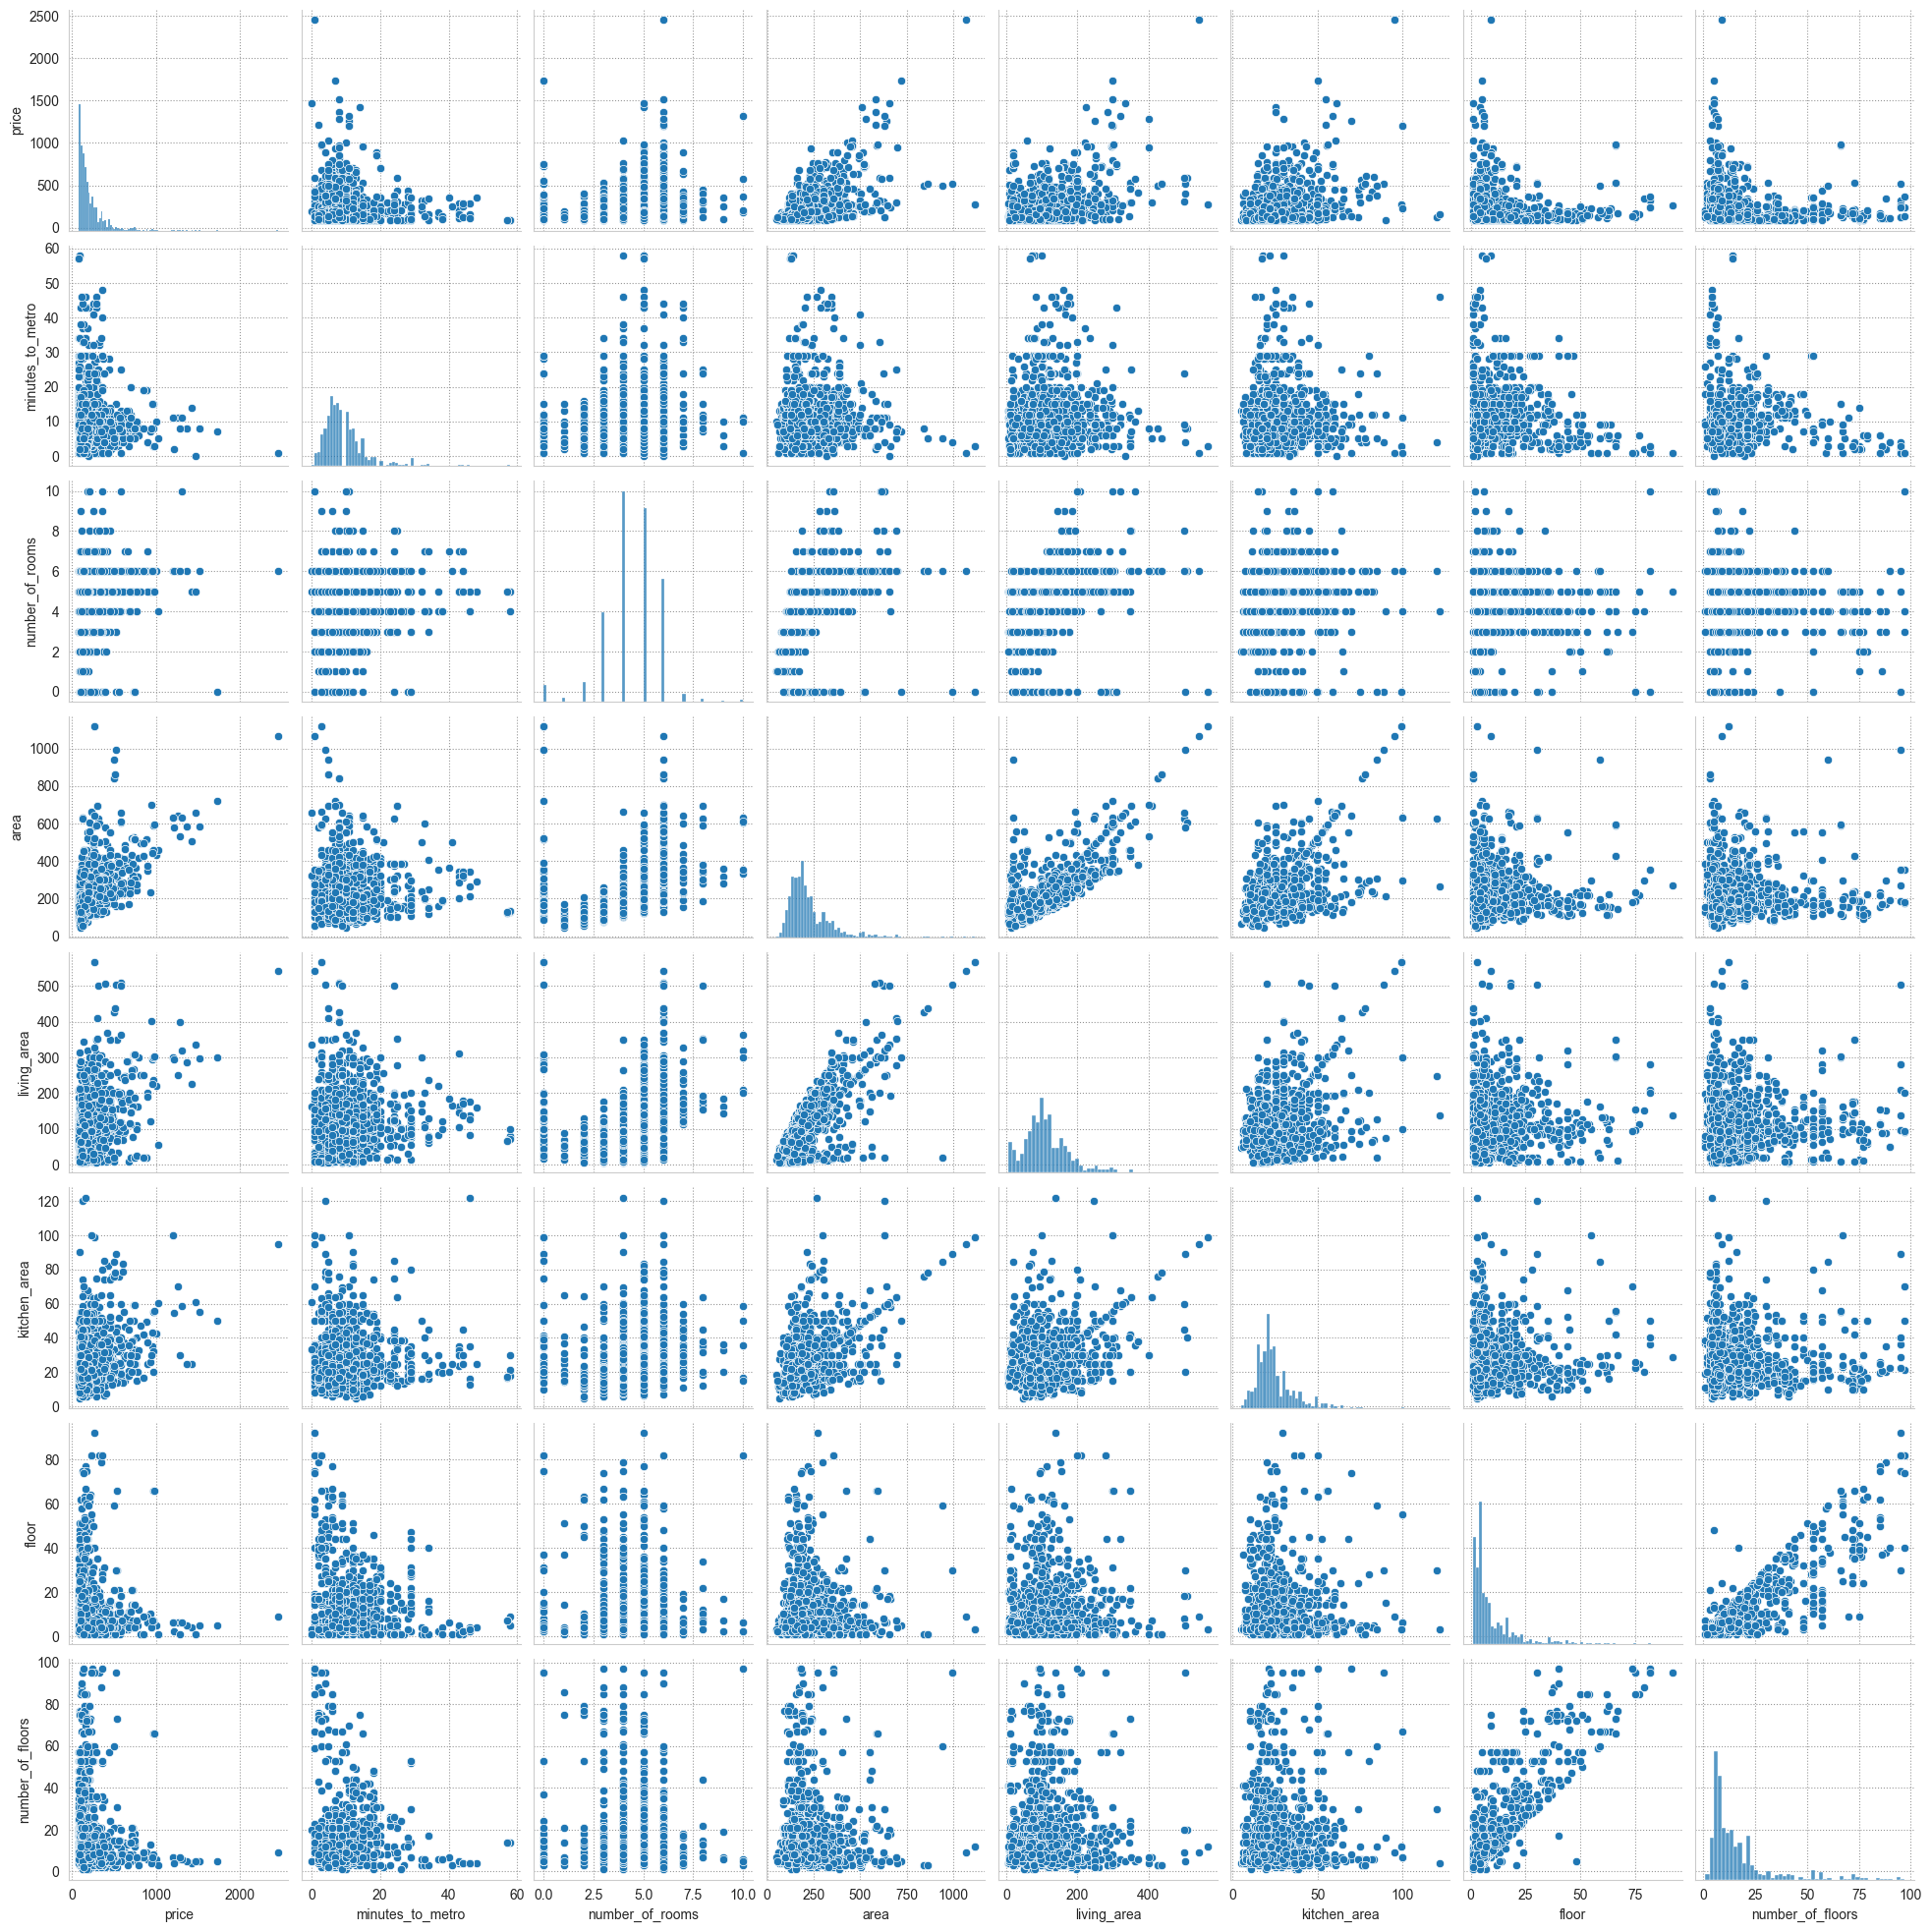

In [22]:
# Исследуем графически зависимость признаков на целевую переменную недвижимости
numeric_col = df.describe().columns
sns.pairplot(df[numeric_col])

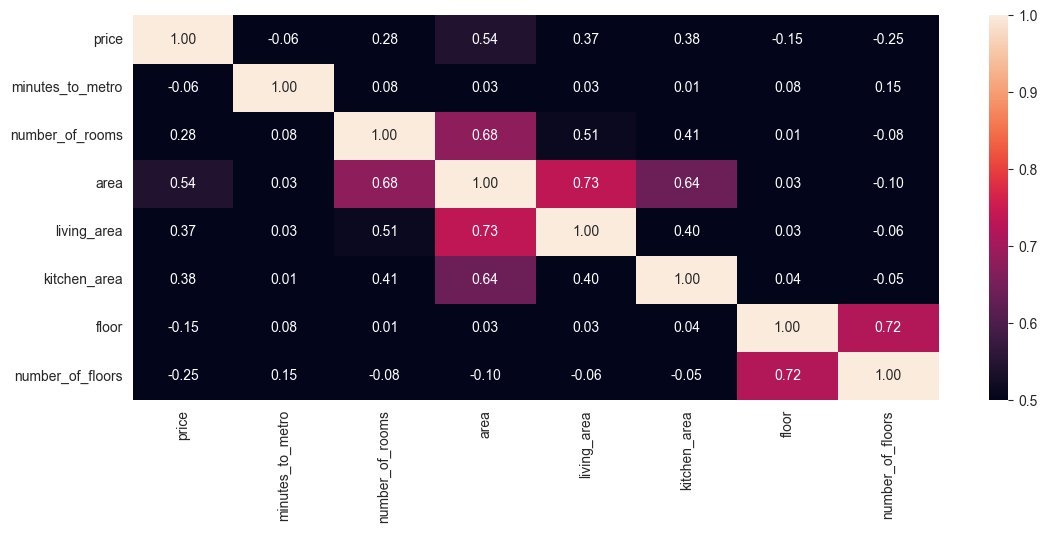

In [23]:
# Исследуем тепловую карту корреляции признаков на целевую переменную для обычной недвижимости
plt.figure(figsize=(13,5))
sns.heatmap(df.corr(method='spearman', numeric_only=True), annot=True, fmt='.2f', vmin=0.5)
plt.show()

Выводы:
1. графически наблюдается связь цены от минут до метро (minutes_to_metro), чем БЛИЖЕ к метро, тем выше цена.
2. по тепловой карте наблюдается положительная корреляция цены от площади (area, living_area, number_of_rooms).
3. наблюдается корреляция признаков: этажа (floor) от этажности аппартаментов (number_of_floors), что избыточно и в дальнейшем можно удалить эти колонки при обнаружении между ними сильной VIF.
4. наблюдается корреляция признаков: площадь (area) коррелирует с жилой площадью (living_area) и с площадью кухни (kitchen_area), также числом комнат (number_of_rooms), что избыточно и в дальнейшем можно удалить эти колонки при обнаружении между ними сильной VIF

In [24]:
# Проверим допущение о мультиколлинеарности
numeric_col = df.drop(columns='price').describe().columns
vif_data = pd.DataFrame()
vif_data.index = numeric_col

vif_data['VIF'] = [variance_inflation_factor(df[numeric_col].values, i) for i in range(len(numeric_col))]
vif_data

,VIF
minutes_to_metro,2.905597
number_of_rooms,7.766630
area,17.115924
living_area,9.035493
kitchen_area,7.643415
floor,6.191350
number_of_floors,6.872840


In [25]:
# Проверим допущение о мультиколлинеарности ещё раз
numeric_col = df.drop(columns=['price', 'living_area', 'kitchen_area', 'number_of_rooms', 'number_of_floors']).describe().columns
vif_data = pd.DataFrame()
vif_data.index = numeric_col

vif_data['VIF'] = [variance_inflation_factor(df[numeric_col].values, i) for i in range(len(numeric_col))]
vif_data

,VIF
minutes_to_metro,2.296103
area,2.529778
floor,1.584655


Вывод: для элитной недвижимости три признака оказались менее 5, то есть с этими признаками можно работать

In [26]:
# Смотрим на колонки с категориальными переменными
df.describe(include='object')

,apartment_type,metro_station,renovation
count,2240,2240,2240
unique,1,203,4
top,Secondary,Спортивная,Designer
freq,2240,122,1341


Выводы:
1. у нас всего 1 тип аппартаментов в датасете - вторичка, поэтому нет смысла учитывать это как признак
2. у нас всего 4 вида ремонта в датасете
3. элитная недвижимость расположена только вблизи третий всех станций метро

In [27]:
StatCriteria().kruskal(df, 'metro_station', 'price')

kruskal
statistic = 682.283
Медианы всех групп не равны (p-value = 0.000).


(np.float64(682.2831699427966), np.float64(2.0772063184079704e-53))

In [28]:
StatCriteria().kruskal(df, 'renovation', 'price')

kruskal
statistic = 41.092
Медианы всех групп не равны (p-value = 0.000).


(np.float64(41.09192415075874), np.float64(6.252128685519662e-09))

Вывод: на стоимость elite недвижимости влияют все категориальные переменные такие как:
1. metro_station,
2. renovation,

поэтому их все придётся учитывать при проведении регрессии.

In [29]:
df['metro_station'] = Encoder().leaveOneOutEncoder(df['metro_station'], df['price'])
df['renovation'] = Encoder().labelEncoder(df['renovation'])

In [30]:
# проверяем датасет
df.head(5)

,price,apartment_type,metro_station,minutes_to_metro,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors,renovation
0,120.0000,Secondary,240.992829,9,4,130.0,67.9,17.4,4,6,1
1,291.9225,Secondary,253.878994,6,4,166.0,101.0,20.0,2,7,1
2,204.0000,Secondary,305.390541,5,4,170.0,88.1,20.7,6,8,3
3,85.0000,Secondary,269.603402,16,4,186.0,102.0,10.0,35,42,3
4,223.4496,Secondary,241.427898,9,5,153.6,125.6,23.0,64,67,1


In [31]:
# подготавливаем данные
exclude_features = ['price', 'apartment_type', 'living_area', 'kitchen_area', 'number_of_rooms']
target = ['price']
X_train, X_test, y_train, y_test = DataPreparation().prepare_data(df, exclude_features, target)

# проводим нормализацию (логарифмирование)
X_train, X_test, y_train, y_test = Normalizer().log_norm(X_train, X_test, y_train, y_test)
X_train, X_test, y_train, y_test = Normalizer().min_max_scaling(X_train, X_test, y_train, y_test)

In [32]:
# Применяем готовую линейную регрессию из библиотеки statsmodels

# Добавим константу как требование OLS
X_train_plus_const = sm.add_constant(X_train, prepend=False)
X_test_plus_const = sm.add_constant(X_test, prepend=False)

# Обучаем модель на обучающей выборке
model = OLS(y_train, X_train_plus_const).fit()

# Прогнозируем на тестовой выборке
y_pred = model.predict(X_test_plus_const)

residuals = y_test.flatten() - y_pred
print(model.summary())

MetricCalculator.show_metrics(y_test.flatten(), y_pred)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     258.8
Date:                Mon, 27 Jan 2025   Prob (F-statistic):          2.57e-234
Time:                        17:39:38   Log-Likelihood:                 1179.9
No. Observations:                1680   AIC:                            -2346.
Df Residuals:                    1673   BIC:                            -2308.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3415      0.018     19.117      0.0

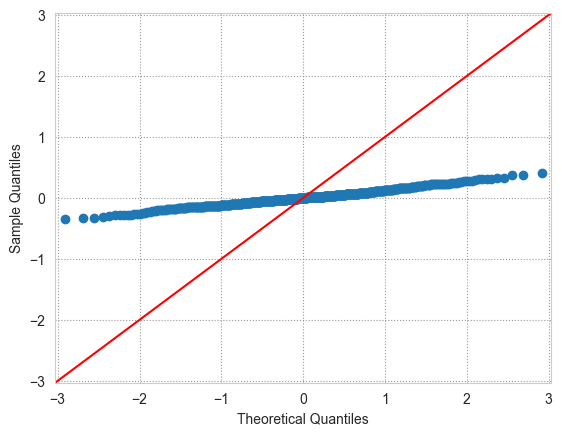

In [33]:
# Проверка на нормальность остатков
fig = sm.qqplot(residuals, line='45')
plt.show()

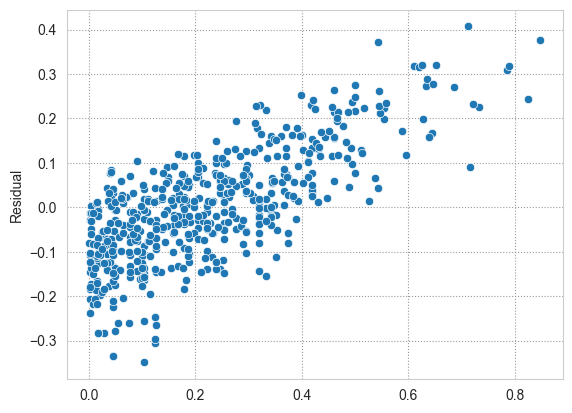

In [34]:
# Проверка на гомоскедастичность визуально
sns.scatterplot(x = y_test.flatten(), y = residuals)
plt.ylabel("Residual")
plt.show()

In [35]:
# Применяем Lasso регрессию
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

# Прогнозируем на тестовой выборке
y_pred = lasso.predict(X_test)

residuals = y_test.flatten() - y_pred

print("Коэффициенты Lasso-регрессии:", lasso.coef_)

MetricCalculator.show_metrics(y_test, y_pred)

Коэффициенты Lasso-регрессии: [ 0.06282829 -0.          0.18085375 -0.         -0.          0.        ]
MAE: 0.1238690653049593
RMSE: 0.15430473860810323
MSE: 0.023809952356915066
MAPE: 964.34092106969
R²: 0.1958773055461862


Выводы: не влияют minutes_to_metro, floor, number_of_floor